# Solve the transistor amplifier problem with DAEs solvers 

## Mathematical modelling

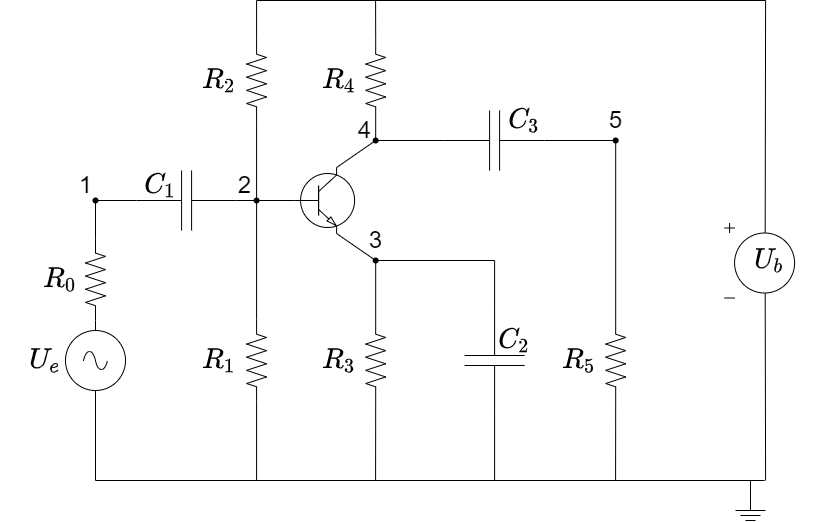

In [1]:
from IPython.display import Image
Image(filename="img/circuit_transistor.png")

Kirchhoff law of currents on nodes 1 to 5:
1. $\frac{U_e-U_1}{R_0} = C_1 (U'_1-U'_2)$
2. $\frac{U_b-U_2}{R_2} + C_1 (U'_1-U'_2) =  \frac{U_2}{R_2} + 0.01F(U_2-U_3)$
3. $F(U_2-U_3) = \frac{U_3}{R_3} + C_2 U'_3$
4. $\frac{U_b-U_4}{R_4} = C_3 (U'_4-U'_5) + 0.99 F(U_2-U_3)$
5. $C_3 (U'_4-U'_5) = \frac{U_5}{R_5}$

with 
- $F(U) = 10^{-6} \left( exp\left( \frac{U}{0.026} \right)-1 \right)$
- $R_0 = 1000 [\Omega], R_i=9000 [\Omega] \quad (i=1...5)$
- $C_i = i \cdot 10^{-6} [F] \quad (i=1,2,3)$
- the initial signal chosen: $U_e(t)= 0.4 \cdot sin(200\pi t)$

If rewritten as $M u'= f(t, u)$ we have:
\begin{equation*}
M = 
\begin{bmatrix}
    -C_1 & C_1  &      &      &     \\
    C_1  & -C_1 &      &      &     \\
         &      & -C_2 &      &     \\
         &      &      & -C_3 & C_3 \\
         &      &      & C_3  & -C_3
\end{bmatrix}
\end{equation*}


To obtain an ODE, the following variable changes are used:
$$U_1-U_2=y_1, U_3=y_2, U_4-U_5=y_3, U_1=z_1, U_4=z_2$$
which gives the reduced equations:
\begin{align*}
        y'&=f(y,z)\\
        0&=g(y,z)
    \end{align*}
with $g$ the sum of the first and last two equations which gives us the following index 1 DAE system :

\begin{align*}
\left\{
\begin{aligned}
        y_1^{'} &= \frac{U_e - z_1}{R_0 C_1} \\
        y_2^{'} &= \frac{F(-y_1 + z_1 - y_2)}{C_2} - \frac{y_2}{C_2 R_3} \\
        y_3^{'} &= \frac{-y_3 + z_2}{R_5 C_3} \\
        0     &= \frac{U_e}{R_0} + \frac{U_b}{R_2} - \frac{z_1}{R_0} - (z_1 - y_1) \cdot (\frac{1}{R_1} + \frac{1}{R_2}) - 0.01 \cdot F(-y_1+z_1 - y_2) \\
        0     &= \frac{U_b}{R_4} - \frac{z_2}{R_4} - \frac{z_2-y_3}{R_5} - 0.99 \cdot F(-y_1+z_1 - y_2)
\end{aligned}
\right.
\end{align*}

The ODE system can be determine by the derivation of the two algebraic contraints :

 \begin{align*}
 \left\{
         \begin{aligned}
        y_1^{'} &= \frac{U_e - z_1}{R_0 C_1} \\
        y_2^{'} &= \frac{F(-y_1 + z_1 - y_2)}{C_2} - \frac{y_2}{C_2 R_3} \\
        y_3^{'} &= \frac{-y_3 + z_2}{R_5 C_3} \\
        z_1' &= \frac{\frac{U_e'}{R_0} + y_1' \left( \frac{1}{R_1} + \frac{1}{R_2} + 0.01 h \right) + 0.01 h y_2'}{\frac{1}{R_0}+ \frac{1}{R_1}+ \frac{1}{R_2} + 0.01 h}\\
        z_2' &= \frac{\frac{y_3'}{R_5} - 0.99 (-h y_1'+ h z_1' - h y_2')}{\frac{1}{R_4}+\frac{1}{R_5}}
        \end{aligned}\right.
\end{align*}
    
with $h(y_1, y_2, z_1) = \frac{10^{-6}}{0.026} exp(\frac{-y_1+z_1-y_2}{0.026})$

## Solving those systems with DAEs solvers

In [2]:
# import solvers
from solvers.bdfSolver import BDFModified
from solvers.sabm import SABM
from solvers.radau import RadauModified
from solvers.rosScipyFinal import Rosenbrock

In [3]:
# import other useful modules
from time import time
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve
import numpy as np

Declare the constants of the transistor amplifier problem:

In [4]:
R0 = 1000
R1 = 9000
R2 = 9000
R3 = 9000
R4 = 9000
R5 = 9000
C1 = 1*1e-6
C2 = 2*1e-6
C3 = 3*1e-6

def F(U): return 1e-6 * (np.exp(U/0.026) - 1)
def Ue(t): return 0.4*np.sin(200*np.pi*t)

Ub = 6

tspan = [0, 0.2]

y0_m = np.array([0., Ub*R1/(R1+R2), Ub*R1/(R1+R2), Ub, 0.]) # initial condition for the system with mass matrix

ini = (Ub*R1)/(R1+R2)
y0 = np.array([-ini, ini, Ub, 0, Ub]) # initial condition for the system with change variables

Create the function describing the DAEs systems such that 𝑀𝑦˙=𝑓(𝑡,𝑦) :

In [5]:
def f_transistor_index1(t, y):
    U1, U2, U3, U4, U5 = y[0], y[1], y[2], y[3], y[4]
    f = 1e-6*(np.exp((U2-U3)/0.026)-1)
    return np.array([(Ue(t)-U1)/R0,
                     Ub/R2 - U2*(1/R1+1/R2) - 0.01*f,
                     f - U3/R3,
                     Ub/R4 - U4/R4 - 0.99*f,
                     -U5/R5])

# mass matrix
M = -np.array([[-C1, C1, 0, 0, 0],
                 [C1, -C1, 0, 0, 0],
                 [0, 0, -C2, 0, 0],
                 [0, 0, 0, -C3, C3],
                 [0, 0, 0, C3, -C3]])

# functions of the rhs linked to the derivatives, it's the rhs of the ODE part of the DAE system
def fun(t, y, x):
    res = np.zeros(len(y))
    res[0] = (Ue(t) - x[0])/(R0*C1)
    res[1] = F(-y[0] + x[0] - y[1])/C2 - y[1]/(C2*R3)
    res[2] = (-y[2] + x[1])/(R5*C3)
    return res

# algebraic constraints
def gun(t, y, x):
    res = np.zeros(len(x))
    res[0] = Ue(t)/R0 + Ub/R2 - x[0]/R0 - (x[0]-y[0]) * \
        (1/R1 + 1/R2) - 0.01*F(-y[0]+x[0]-y[1])
    res[1] = Ub/R4 - x[1]/R4 - (x[1]-y[2])/R5 - 0.99*F(-y[0]+x[0]-y[1])
    return res

Parameters of the DAEs solvers similar to those scipy solve_ivp:

In [6]:
kwargsBDF = {
    'fun': f_transistor_index1,
    't_span': tspan,
    'y0': y0_m,
    'mass': M,
    'method': BDFModified,
    'rtol': 1e-5,
    'atol': 1e-5
}

kwargsRadau = {
    'fun': f_transistor_index1,
    't_span': tspan,
    'y0': y0_m,
    'mass': M,
    'method': RadauModified,
    'rtol': 1e-5,
    'atol': 1e-5,
    'dense_output': False
}

kwargsSABM = {
    'fun': fun,
    't_span': tspan,
    'y0': y0,
    'method': SABM,
    'gun': gun,
    'num_diff': 3,
    'order': 2,
    'atol': 1e-5,
    'rtol': 1e-5,
    'mode': 'Explicit'
}

Solve the DAEs:

In [7]:
kwargs = kwargsSABM

before = time()
sol = solve_ivp(**kwargs)
print(f'Success: {sol.success}')
print(f'Temps de calcul : {time()-before}')
t = sol.t

if kwargs["method"] == SABM:
    U5 = sol.y[4, :] - sol.y[2,:] 
else:
    U5 = sol.y[4, :]

Success: True
Temps de calcul : 5.556240081787109


Solve the ODEs for the reference solution:

In [8]:
def solve_ODE():
    def dUedt(t): return 200*np.pi*0.4*np.cos(200*np.pi*t) 
    def transistorOde(t, y):
        y1, y2, y3, z1, z2 = y
        h = (1e-6)/(0.026) * np.exp((-y1+z1-y2)/0.026)
        
        dy1dt = (Ue(t) - z1)/(R0*C1)
        dy2dt = F(-y1+z1-y2)/C2 - y2/(C2*R3)
        dy3dt = (-y3+z2)/(R5*C3)
        dz1dt = (dUedt(t)/R0 + dy1dt*(1/R1 + 1/R2 + 0.01*h) + 0.01*h*dy2dt)/(1/R0 + 1/R1 + 1/R2 + 0.01*h)
        dz2dt = (dy3dt/R5 - 0.99*(-h*dy1dt + h*dz1dt - h*dy2dt))/(1/R4 + 1/R5)
        return np.array([dy1dt, dy2dt, dy3dt, dz1dt, dz2dt])
    
    y0 = np.array([-ini, ini, Ub, 0, Ub])
    sol_ODE = solve_ivp(fun=transistorOde, t_span=[0, sol.t[-1]], y0=y0, rtol=1e-12,
                        atol=1e-12, method='Radau', t_eval=sol.t)
    y1, y2, y3, z1, z2 = sol_ODE.y[0, :], sol_ODE.y[1, :], sol_ODE.y[2, :], sol_ODE.y[3, :], sol_ODE.y[4,:]
    
    U5_ODE = z2 - y3
    return sol_ODE.t, U5_ODE

t_ODE, U5_ODE = solve_ODE()

Plot signals $U_5$ and $U_e$

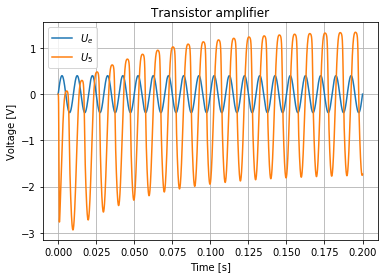

In [9]:
plt.figure()
plt.plot(t, Ue(t))
plt.plot(t, U5)
plt.xlabel("Time [s]")
plt.ylabel("Voltage [V]")
plt.legend([r"$U_e$", "$U_5$"])
plt.title("Transistor amplifier")
plt.grid()
plt.show()

Plot of the error in comparaison with the ODE solution:

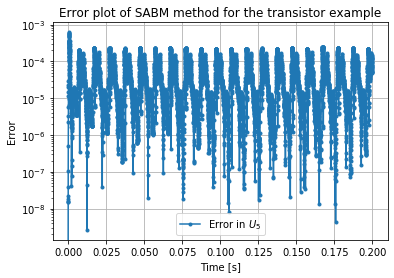

In [10]:
plt.figure()
plt.semilogy(t, abs(U5_ODE - U5), ".-", label='Error in $U_5$')
plt.title(
    f'Error plot of {kwargs["method"].__name__} method for the transistor example')
plt.xlabel('Time [s]')
plt.ylabel('Error')
plt.grid()
plt.legend()
plt.show()